请输入豆瓣电影地址:
https://movie.douban.com/subject/26741568/
我的恐怖妻子 僕のヤバイ妻 (2016) 


导演: 三宅喜重 / 国本雅广
编剧: 黑岩勉
主演: 伊藤英明 / 木村佳乃 / 相武纱季 / 浅香航大 / 真岛秀和 / 木村绿子 / 高桥一生 / 宫迫博之 / 佐藤隆太
类型: 剧情
官方网站: www.ktv.jp/yabatsuma/index.html
制片国家/地区: 日本
语言: 日语
首播: 2016-04-19(日本)
集数: 9
单集片长: 50分钟
又名: 我的危险妻子 / 我的糟糕妻子 / 我的愚蠢丈夫(豆友译名) / Boku no Yabai Tsuma / My Dangerous Wife
IMDb链接: tt5524370
 



                                　　居住在某富人社区的望月夫妇过着令人欣羡的幸福生活。望月幸平（伊藤英明 饰）出身贫寒，不过他的妻子真理亚（木村佳乃 饰）家境优渥。真理亚的父母去世后留下了丰厚的遗产，利用这笔钱幸平经营了一家咖啡店。日常里幸平的衣食起居全由真理亚一人照顾，妻子体贴入微，甚至连望月老家的母亲和姐姐也都关爱有加。可就是这样一位近乎完美的妻子，却因无微不至的关怀而引来幸平越来越多的反感。他与咖啡店主厨北里杏男（相武纱季 饰）陷入不伦之恋，后者则怂恿他杀掉妻子。
                                    
                                　　就当计划准备实施当天，妻子疑似遭人绑架。对方索要两亿日元赎金，否则将杀掉真理亚。看似老天帮助了幸平，然而接下来的事实却让他惊恐万分……
                         







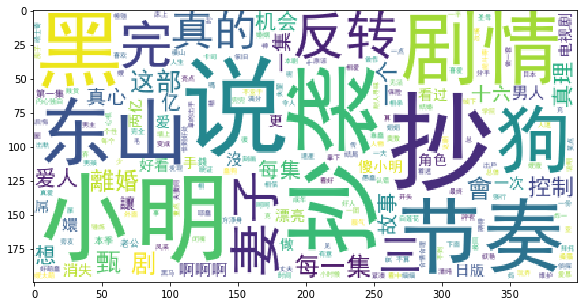

In [18]:
# coding=utf-8

from urllib.parse import urljoin
import requests
import sys
import warnings
warnings.filterwarnings("ignore")
import jieba
import numpy
import codecs
import re
import pandas as pd
import matplotlib.pyplot as plt
from urllib import request
from bs4 import BeautifulSoup as bs
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
from wordcloud import WordCloud

# 设置递归深度
sys.setrecursionlimit(2000)
    
    
# 解析电影页
def parse_subject(url):
    r = s.get(url, headers=headers, timeout=5)
    html = r.text
    soup = bs(html, 'html.parser')
    title = soup.find('span', attrs={'property': 'v:itemreviewed'}).text
    year = soup.find('span', class_='year').text
    pic = soup.find('a', class_='nbgnbg').find('img').get('src')
    info = soup.find('div', id='info').text
    summary = soup.find('span', attrs={'property': 'v:summary'}).text
    return title, year, pic, info, summary

# 解析短评
def parse_comment(url, headers):
    global comments, page
    r = s.get(url, headers=headers, timeout=5)
    html = r.text
    soup = bs(html, 'html.parser')
    comment_divs = soup.find_all('div', class_='comment')
    if comment_divs is not None:
        comments += ''.join([item.find('p').string.strip() for item in comment_divs])
    next_page = soup.find('a', class_='next')
    if next_page is not None and page < 30:
        page += 1
        return parse_comment(urljoin(next_page.get('href'), url), headers)
    return comments

def generate_cloud():
    global comments
    pattern = re.compile(r'[\u4e00-\u9fa5]+')
    filterdata = re.findall(pattern, comments)
    new_comments = ''.join(filterdata)

    #使用结巴分词进行中文分词
    segment = jieba.lcut(new_comments)
    words_df = pd.DataFrame({'segment':segment})

    #去掉停用词
    stopwords = pd.read_csv('stopwords.txt', index_col=False, quoting=3, sep='\t', names=['stopword'], encoding='utf-8')#quoting=3全不引用
    words_df = words_df[~words_df.segment.isin(stopwords.stopword)]

    #统计词频
    words_stat = words_df.groupby(by=['segment'])['segment'].agg({"计数":numpy.size})
    words_stat = words_stat.reset_index().sort_values(by=["计数"], ascending=False)

    #用词云进行显示
    wordcloud = WordCloud(font_path='simhei.ttf', background_color='white', max_font_size=80)
    word_frequence = {x[0]:x[1] for x in words_stat.head(1000).values}

    wordcloud = wordcloud.fit_words(word_frequence)
    plt.imshow(wordcloud)

if __name__ == '__main__':
    s = requests.Session()
    cookie = input('请把登录后获取到的cookie粘贴在这里:\n')
    headers = {
    'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'Accept-Encoding':'gzip, deflate, br',
    'Accept-Language':'zh,en;q=0.9,en-US;q=0.8,zh-CN;q=0.7',
    'Cache-Control':'no-cache',
    'Cookie':cookie,
    'Connection':'keep-alive',
    'Host':'movie.douban.com',
    'Pragma':'no-cache',
    'Referer':'https://movie.douban.com/',
    'Upgrade-Insecure-Requests':'1',
    'User-Agent':'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36' 
    }
    comments = ''
    page = 1
    url = input('请输入豆瓣电影地址:\n')
    title, year, pic, info, summary = parse_subject(url)
    print(title, year, '\n')
    print(info, '\n\n')
    print(summary, '\n\n')
    print('\n================================\n\n')
    comment_url = urljoin(url, 'comments?start=0&limit=20&sort=new_score&status=P&percent_type=')
    parse_comment(comment_url, headers)
    generate_cloud()